### Derived code from 
https://www.kaggle.com/code/ishank201202/generate-music-with-variational-autoencoder
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

### Setup and Initialization

This notebook relies on several packages which can be installed using the following commands:


# Commands to install necessary packages

In [ ]:
!pip install tensorflow-addons
!pip install tensorflow
!pip install -q git+https://github.com/tensorflow/docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install --upgrade librosa
!pip install noisereduce

In [ ]:
!pip install librosa scipy numpy soundfile

# Import libraries

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import librosa
import numpy as np
import pandas as pd
import os


In [ ]:
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

import librosa.display

# Setup variables

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = 60000
BATCH_SIZE = 10
# BATCH_SIZE = 32
test_size = 10000
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

# for google colab run
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/My Drive/Data/genres_original'

seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Loading

The dataset is loaded and preprocessed here, ensuring it is suitable for use with our VAE model.


In [ ]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) #65,32,53,22,19,80,89,
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]
    return TrackSet_1, TrackSet_2

def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,90001)
    return data_

map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

## Models

In [ ]:
class Resnet1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, type='encode'):
        super(Resnet1DBlock, self).__init__()
        self.type = type
        if type == 'encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
            self.projection = layers.Conv1D(filters, 1, padding="same")  # Projection layer
        elif type == 'decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
            self.projection = layers.Conv1DTranspose(filters, 1, padding="same")  # Projection layer

    def call(self, input_tensor):
        x = input_tensor
        x = tf.nn.relu(x)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = tf.nn.relu(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = tf.nn.relu(x)

        # Apply projection to ensure shape compatibility
        if x.shape[-1] != input_tensor.shape[-1]:
            input_tensor = self.projection(input_tensor)

        x += input_tensor
        return x


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

@tf.keras.saving.register_keras_serializable()
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,90001)),
                layers.Conv1D(64, 1, 2),
                Resnet1DBlock(64, 1, type='encode'),
                layers.Conv1D(128, 1, 2),
                Resnet1DBlock(128, 1, type='encode'),
                layers.Conv1D(256, 1, 2),
                Resnet1DBlock(256, 1, type='encode'),
                layers.Flatten(),
                layers.Dense(latent_dim + latent_dim)
            ]
        )
        self.encoder.summary()
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Dense(256 * 1, activation='relu'),
                layers.Reshape(target_shape=(1, 256)),
                Resnet1DBlock(256, 1, type='decode'),
                layers.Conv1DTranspose(128, 1, padding="same"),
                Resnet1DBlock(128, 1, type='decode'),
                layers.Conv1DTranspose(64, 1, padding="same"),
                Resnet1DBlock(64, 1, type='decode'),
                layers.Conv1DTranspose(90001, 1, padding="same")
            ]
        )
        self.decoder.summary()

 # generates new samples from the latent space
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [ ]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [ ]:
@tf.function
def train_step(model, x, optimizer):

    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveshow(wave[0], sr=3000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [ ]:
def train(train_dataset, test_dataset, model, save, epochs):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print(f'Epoch: {epoch}/{epochs}, Test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}')
        generate_and_save_images(model, epoch, test_sample, save)

## Helper Functions

Several utility functions are defined below to assist with tasks like data preprocessing, model evaluation, and results visualization.


In [ ]:
def plot_waveshows(audio_paths, sr=3000):
    """
    Plot waveforms for a list of audio files.

    Parameters:
    - audio_paths (list of str): List of paths to audio files.
    - sr (int): Sample rate of the audio files (default is 3000).
    """
    plt.figure(figsize=(18, 15))

    num_tracks = len(audio_paths)
    num_cols = 4
    num_rows = (num_tracks + num_cols - 1) // num_cols  # Calculate number of rows needed

    for i, path in enumerate(audio_paths):
        plt.subplot(num_rows, num_cols, i + 1)
        audio_data, _ = librosa.load(path, sr=sr)
        librosa.display.waveshow(audio_data, sr=sr)
        plt.title(f'Track {i + 1}')

    plt.tight_layout()
    plt.show()

### Load a presaved model

In [ ]:
# Load a previously run model for faster execution and faster run time
model = tf.keras.models.load_model('cvae_model_rock_v1.keras', custom_objects={'CVAE': CVAE})

### Sample

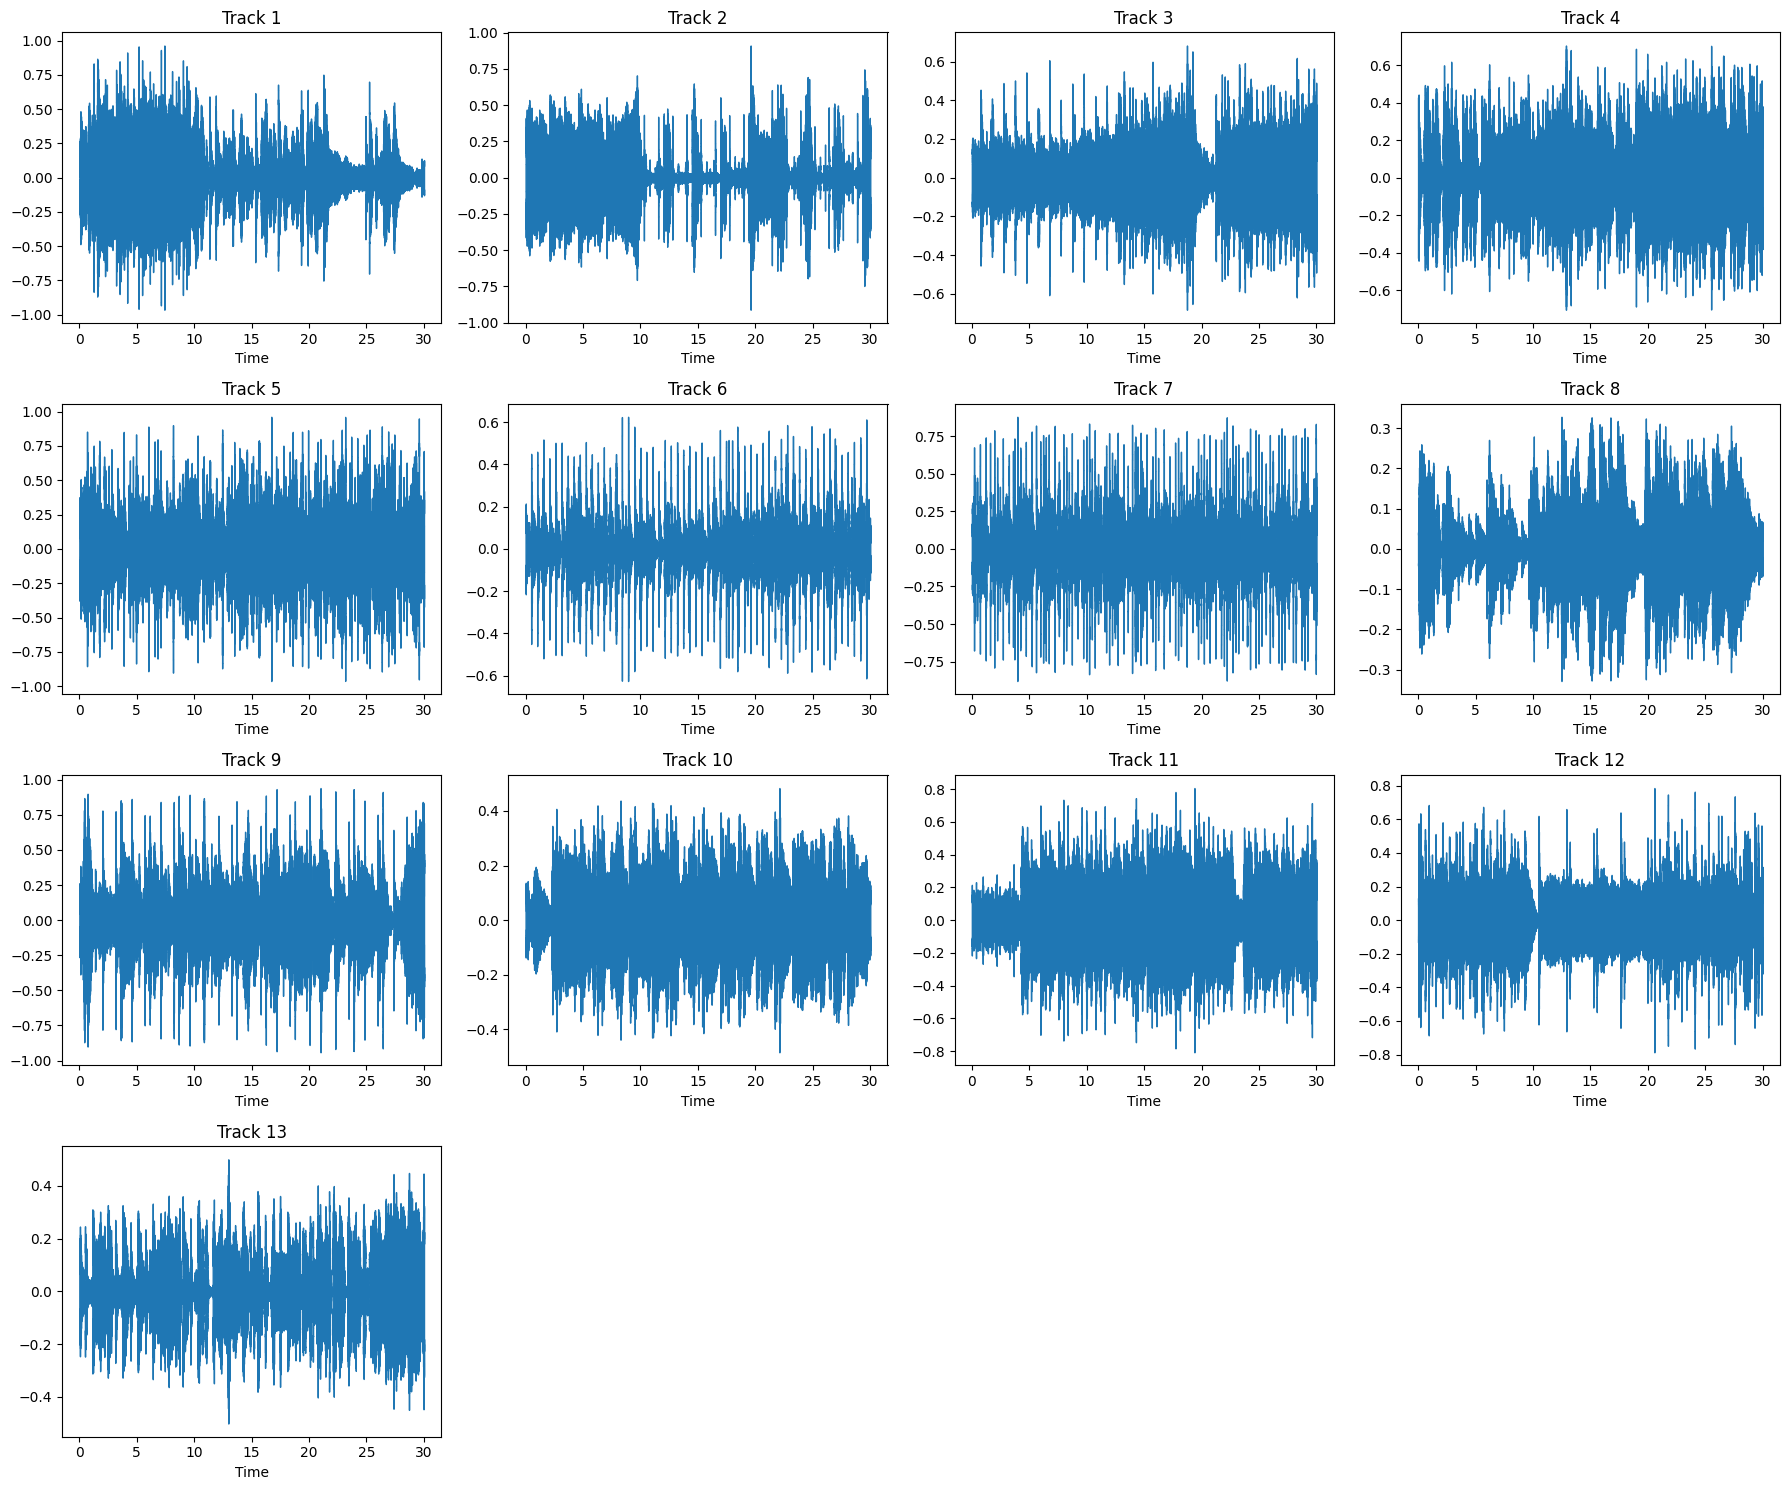

In [ ]:
import librosa.display

sample = TrackSet_1[1]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)

plot_waveshows(TrackSet_1)
# plt.figure(figsize=(18,15))
# for i in range(4):
#     plt.subplot(4, 4, i + 1)
#     j = load(TrackSet_1[i])
#     librosa.display.waveshow(j[0], sr=3000)
# plt.tight_layout()
# plt.show()

## Execution and Analysis

Here, we run the model and analyze the results, focusing on the ELBO metric which includes the Reconstruction Loss and KL Divergence.


In [ ]:
TrackSet_1, TrackSet_2 = DatasetLoader('rock')

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [ ]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [ ]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

In the context of VAEs, the ELBO can be broken down into two parts:
ELBO=Reconstruction Loss+KL Divergence

Reconstruction Loss: Measures how well the decoder reconstructs the input data from the latent space. This is often calculated using Mean Squared Error (MSE) or Mean Absolute Error (MAE).

KL Divergence: Measures the difference between the learned latent distribution and the prior distribution (typically a standard normal distribution).

KL Divergence
KL Divergence measures how much the learned latent distribution deviates from the prior distribution. While this is part of the loss function during training, monitoring it separately can help you understand how well the model's latent space aligns with the prior.

Lower (more negative) ELBO values indicate a better model because they suggest better reconstruction and closer approximation to the prior distribution.

Initial Run:
Epoch: 20, Test set ELBO: -15086.6826171875, time elapse for current epoch: 0.7055466175079346

Longer Epoch Run
Epoch: 30, Test set ELBO: -9076.654296875, time elapse for current epoch: 0.3031611442565918



Epoch: 30/30, Test set ELBO: 4682.80712890625, time elapse for current epoch: 0.3030853271484375


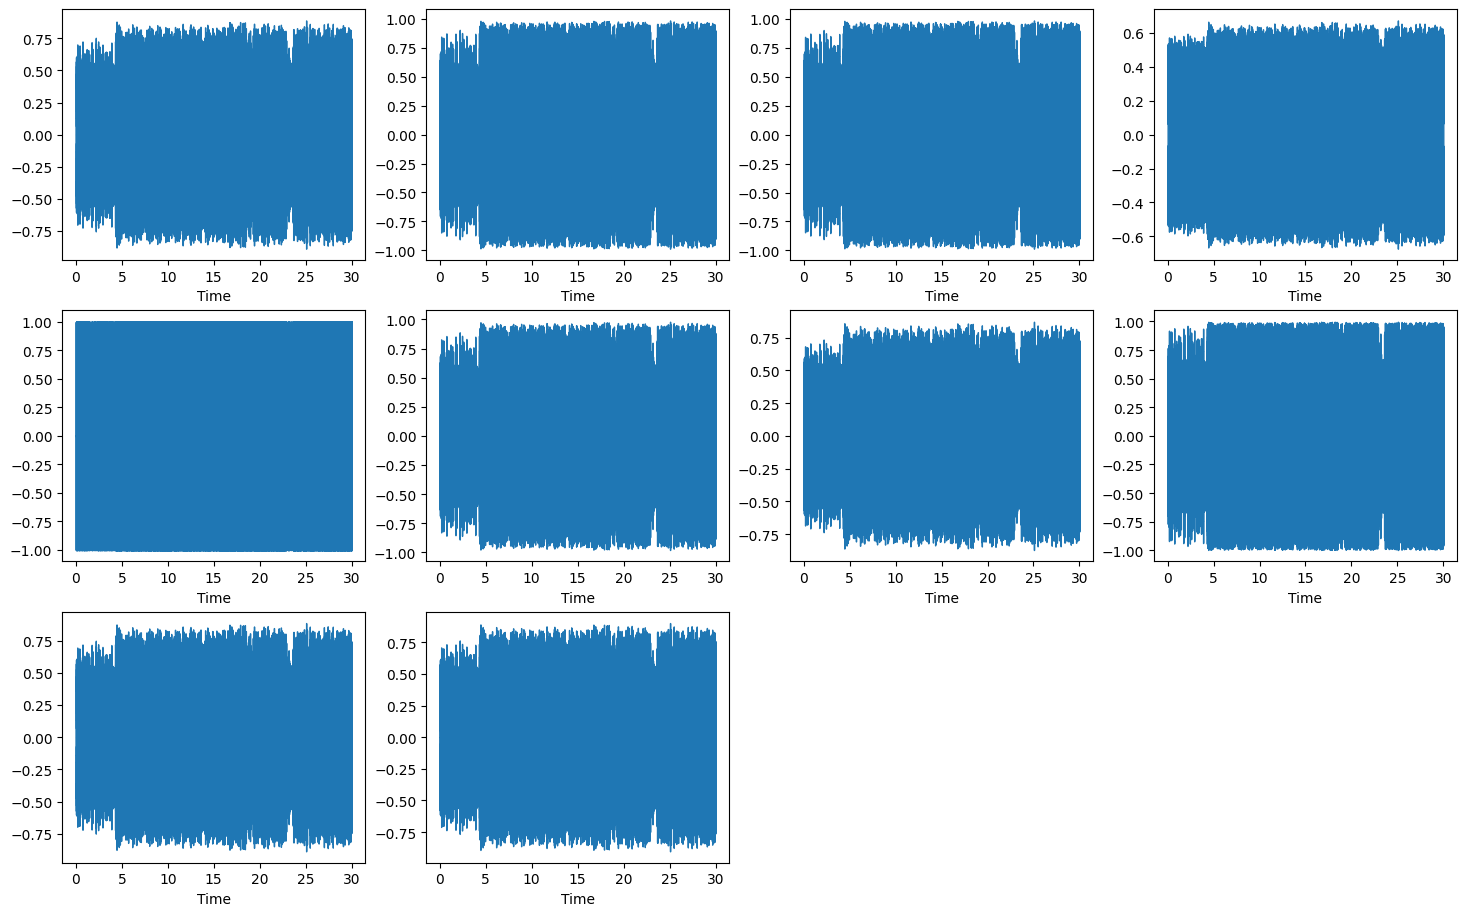

In [ ]:
# generate_and_save_images(model, 0, test_sample, 'rock')

train(train_dataset, test_dataset, model, 'rock',epochs=epochs)

In [ ]:
model.save('cvae_model_rock_v1.keras')

In [ ]:
def inference(test_dataset, model):
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset, model)

In [ ]:
# prompt: size and number of files in saved_musics

print(f"Number of files in saved_musics: {len(saved_musics)}")

for file in saved_musics:
    print(f"{file}")


In [ ]:
import soundfile as sf
import noisereduce as nr
import IPython.display as ipd

# Sample rate
sr = 3000

# Replace 'saved_musics[0][0]' with your actual audio data
music1 = saved_musics[0][0]

# Display original audio
ipd.display(ipd.Audio(music1, rate=sr))

# Perform noise reduction
cleaned_audio = nr.reduce_noise(y=music1, sr=sr, time_mask_smooth_ms=100)  # Set time_mask_smooth_ms to 100ms

# Display cleaned audio
ipd.display(ipd.Audio(cleaned_audio, rate=sr))


# Save the audio files
sf.write('generated_music.wav', music1, sr)
sf.write('cleaned_music.wav', cleaned_audio, sr)


In [ ]:
music2=saved_musics[5]
ipd.Audio(music2,rate=3000)


In [ ]:
music3=saved_musics[9][0]
ipd.Audio(music3,rate=3000)